In [39]:
import os
import cv2
import numpy as np
import math
import sys

import dlib
import glob
from skimage import io


def readImages(path) :
    
    #Create array of array of images.
    imagesArray = [];
    
    #List all files in the directory and read points from text files one by one
    for filePath in os.listdir(path):
        if filePath.endswith(".jpg") or filePath.endswith(".png"):
            # Read image found.
            img = cv2.imread(os.path.join(path,filePath));

            # Convert to floating point
            img = np.float32(img)/255.0;

            # Add to array of images
            imagesArray.append(img);
            
    return imagesArray;

def readPoints(path) :
    predictor_path = "../Models/dlib/shape_predictor_68_face_landmarks.dat"
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    
    # Create an array of array of points.
    pointsArray = [];

    for filePath in os.listdir(path):
        fp = []
        if filePath.endswith(".jpg") or filePath.endswith(".png"):
            # Read image found.
            img = cv2.imread(os.path.join(path,filePath));
            dets = detector(img, 1)
    
            for k, d in enumerate(dets):
                shape = predictor(img, d)                                            
                fp = np.array([[p.x, p.y] for p in predictor(img, d).parts()])
               
            pointsArray.append(fp)  
            
    return pointsArray;

def similarityTransform(inPoints, outPoints) :
    s60 = math.sin(60*math.pi/180);
    c60 = math.cos(60*math.pi/180);  
  
    inPts = np.copy(inPoints).tolist();
    outPts = np.copy(outPoints).tolist();
    
    xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0];
    yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1];
    
    inPts.append([np.int(xin), np.int(yin)]);
    
    xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0];
    yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1];
    
    outPts.append([np.int(xout), np.int(yout)]);
    
    tform = cv2.estimateRigidTransform(np.array([inPts]), np.array([outPts]), False);
    
    return tform;


# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True

# Calculate delanauy triangle
def calculateDelaunayTriangles(rect, points):
    # Create subdiv
    subdiv = cv2.Subdiv2D(rect);
   
    # Insert points into subdiv
    for p in points:
        subdiv.insert((p[0], p[1]));

   
    # List of triangles. Each triangle is a list of 3 points ( 6 numbers )
    triangleList = subdiv.getTriangleList();

    # Find the indices of triangles in the points array

    delaunayTri = []
    
    for t in triangleList:
        pt = []
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            for j in xrange(0, 3):
                for k in xrange(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)                            
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        

    
    return delaunayTri


def constrainPoint(p, w, h) :
    p =  ( min( max( p[0], 0 ) , w - 1 ) , min( max( p[1], 0 ) , h - 1 ) )
    return p;

# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst


# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in xrange(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    
    size = (r2[2], r2[3])

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    
    img2Rect = img2Rect * mask

    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
     
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect


w = 600
h = 600

# images = readImages("../Data/korean")
# allPoints = readPoints("../Data/korean");
images = readImages("../Data/korean")
allPoints = readPoints("../Data/korean");

print("Data Loading is Done!")

Data Loading is Done!


In [2]:
print(len(images))
print(len(allPoints))


50
50


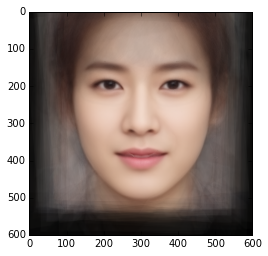

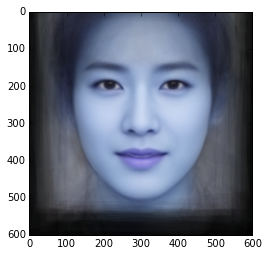

In [40]:
    # Eye corners
    eyecornerDst = [ (np.int(0.3 * w ), np.int(h / 3)), (np.int(0.7 * w ), np.int(h / 3)) ];
    
    imagesNorm = [];
    pointsNorm = [];
    
    # Add boundary points for delaunay triangulation
    boundaryPts = np.array([(0,0), (w/2,0), (w-1,0), (w-1,h/2), ( w-1, h-1 ), ( w/2, h-1 ), (0, h-1), (0,h/2) ]);
    
    # Initialize location of average points to 0s
    pointsAvg = np.array([(0,0)]* ( len(allPoints[0]) + len(boundaryPts) ), np.float32());
    
    n = len(allPoints[0]);

    numImages = len(images)
    
    # Warp images and trasnform landmarks to output coordinate system,
    # and find average of transformed landmarks.
    
    for i in xrange(0, numImages):

        points1 = allPoints[i];

        # Corners of the eye in input image
        eyecornerSrc  = [ allPoints[i][36], allPoints[i][45] ] ;
        
        # Compute similarity transform
        tform = similarityTransform(eyecornerSrc, eyecornerDst);
        
        # Apply similarity transformation
        img = cv2.warpAffine(images[i], tform, (w,h));

        # Apply similarity transform on points
        points2 = np.reshape(np.array(points1), (68,1,2));        
        
        points = cv2.transform(points2, tform);
        
        points = np.float32(np.reshape(points, (68, 2)));
        
        # Append boundary points. Will be used in Delaunay Triangulation
        points = np.append(points, boundaryPts, axis=0)
        
        # Calculate location of average landmark points.
        pointsAvg = pointsAvg + points / numImages;
        
        pointsNorm.append(points);
        imagesNorm.append(img);
    

    
    # Delaunay triangulation
    rect = (0, 0, w, h);
    dt = calculateDelaunayTriangles(rect, np.array(pointsAvg));

    # Output image
    output = np.zeros((h,w,3), np.float32());

    # Warp input images to average image landmarks
    for i in xrange(0, len(imagesNorm)) :
        img = np.zeros((h,w,3), np.float32());
        # Transform triangles one by one
        for j in xrange(0, len(dt)) :
            tin = []; 
            tout = [];
            
            for k in xrange(0, 3) :                
                pIn = pointsNorm[i][dt[j][k]];
                pIn = constrainPoint(pIn, w, h);
                
                pOut = pointsAvg[dt[j][k]];
                pOut = constrainPoint(pOut, w, h);
                
                tin.append(pIn);
                tout.append(pOut);
            
            
            warpTriangle(imagesNorm[i], img, tin, tout);


        # Add image intensities for averaging
        output = output + img;


    # Divide by numImages to get average
    output = output / numImages;
   
img = np.uint8(output*255);
%matplotlib inline
from matplotlib import pyplot as plt
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_org = img_rgb.copy()


plt.imshow(img_rgb)
plt.show()

plt.imshow(img)
plt.show()


[239 234 235]
<type 'numpy.uint8'>


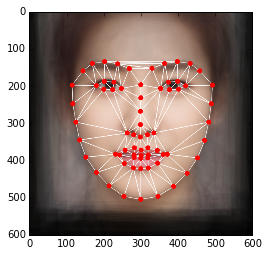

Number of faces detected: 1


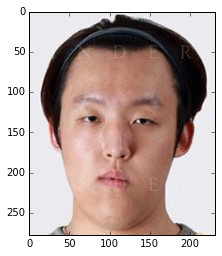

In [44]:
def FacialPointDetector( img, img_rgb ):
    fp = []
    predictor_path = "../Models/dlib/shape_predictor_68_face_landmarks.dat"
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    dets = detector(img, 1)
    print("Number of faces detected: {}".format(len(dets)))

    for k, d in enumerate(dets):
        shape = predictor(img, d)
        fp = np.array([[p.x, p.y] for p in predictor(img, d).parts()])
        
    return fp

fp = []
for i in range(0,68,1):
    x1 = pointsAvg[i][0]
    y1 = pointsAvg[i][1]
    cv2.circle( img_rgb, (int(x1), int(y1)), 6, (255,0,0), cv2.cv.CV_FILLED, cv2.CV_AA, 0 )
    fp.append((int(x1), int(y1)))

#img2 = cv2.imread('../FaceMorphing/yusheng.jpg')
#img2 = cv2.imread('../Data/plastic/2-13.png')
img2 = cv2.imread('../Data/plastic/2-47.png')
#img2 = cv2.imread('../Data/plastic/2-21.png')

img_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2_org = img_rgb2.copy()


print(img2[1][1])
print(type(img_rgb2[1][1][1]))

plt.imshow(img_rgb)
plt.show()

fp2 = FacialPointDetector( img2, img_rgb2 )

plt.imshow(img_rgb2)
plt.show()

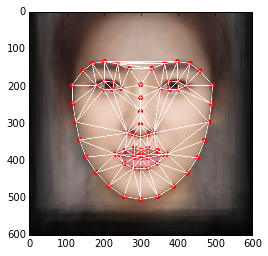

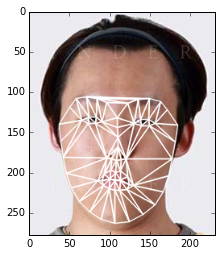

In [45]:
def DrawFacialTriangulation( img, img_rgb, fp, readTheFile ) :
    if readTheFile == False:
        # Rectangle to be used with Subdiv2D
        size = img.shape
        rect = (0, 0, size[1], size[0])

        # Create an instance of Subdiv2D
        subdiv = cv2.Subdiv2D(rect);

        # #test
        # cv2.rectangle(img_rgb, (rect[0],rect[1]), (rect[2],rect[3]), (0, 255, 0), 10)
        # plt.imshow(img_rgb)
        # plt.show()

        # Insert points into subdiv
        for i in range(0,68,1):
            subdiv.insert((fp[i][0], fp[i][1]))

        # Draw delaunay triangles
        lmList = []
        trList, lmList = draw_delaunay( img_rgb, subdiv, (255, 255, 255), fp );
        return trList, lmList
    else:
        # Read triangles from tri.txt
        trList = []
        with open("../Models/triIdx.txt") as file :
            for line in file :
                x,y,z = line.split()

                x = int(x)
                y = int(y)
                z = int(z)
                
                pt1 = (fp[x][0], fp[x][1])
                pt2 = (fp[y][0], fp[y][1])
                pt3 = (fp[z][0], fp[z][1])
                
                cv2.line(img_rgb, pt1, pt2, (255, 255, 255), 1, cv2.CV_AA, 0)
                cv2.line(img_rgb, pt2, pt3, (255, 255, 255), 1, cv2.CV_AA, 0)
                cv2.line(img_rgb, pt3, pt1, (255, 255, 255), 1, cv2.CV_AA, 0)
                trList.append((pt1, pt2, pt3))
        
        return trList
    
trList = DrawFacialTriangulation( output, img_rgb, fp, True )

plt.imshow(img_rgb)
plt.show()

trList2 = DrawFacialTriangulation( img2, img_rgb2, fp2, True )
plt.imshow(img_rgb2)
plt.show()


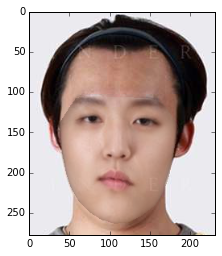

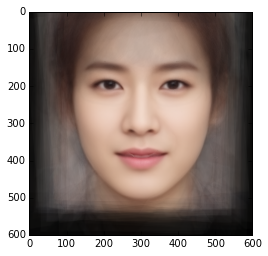

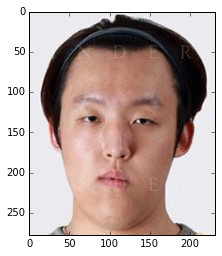

In [46]:
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst


def FaceMorphing( img, img2, fp, fp2, trList, trList2, alpha ):
    # Generated Facial Points 
    points = []
    
#     # Compute weighted average point coordinates
#     for i in range(0,68,1):
#         x = int(( 1 - alpha ) * fp[i][0] + alpha * fp2[i][0])
#         y = int(( 1 - alpha ) * fp[i][1] + alpha * fp2[i][1])
#         points.append((x,y))
     
#     # Allocate space for final output
#     imgMorph = np.zeros(img.shape, dtype = img.dtype)
    
#     trListM = []
#     with open("triIdx.txt") as file :
#         for line in file :
#             x,y,z = line.split()

#             x = int(x)
#             y = int(y)
#             z = int(z)

#             pt1 = (points[x][0], points[x][1])
#             pt2 = (points[y][0], points[y][1])
#             pt3 = (points[z][0], points[z][1]) 
#             trListM.append((pt1, pt2, pt3))
    
    imgMorph = img.copy()
    
    for i in range(0,len(trList),1) :
        # Get coordinates of a triangle
        t1 = [trList[i][0],trList[i][1],trList[i][2]]
        t2 = [trList2[i][0],trList2[i][1],trList2[i][2]]
        # t = [trListM[i][0],trListM[i][1],trListM[i][2]]
        t = [trList[i][0],trList[i][1],trList[i][2]]
        
        # Find bounding rectangle for each triangle
        r1 = cv2.boundingRect(np.float32([t1]))
        r2 = cv2.boundingRect(np.float32([t2]))
        r = cv2.boundingRect(np.float32([t]))

        # Offset points by left top corner of the respective rectangles
        t1Rect = []
        t2Rect = []
        tRect = []


        for i in xrange(0, 3):
            tRect.append(((t[i][0] - r[0]),(t[i][1] - r[1])))
            t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
            t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


        # Get mask by filling triangle
        mask = np.zeros((r[3], r[2], 3), dtype = np.float32)
        cv2.fillConvexPoly(mask, np.int32(tRect), (1.0, 1.0, 1.0), 16, 0);

        # Apply warpImage to small rectangular patches
        img1Rect = img[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
        img2Rect = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

        size = (r[2], r[3])
        warpImage1 = applyAffineTransform(img1Rect, t1Rect, tRect, size)
        warpImage2 = applyAffineTransform(img2Rect, t2Rect, tRect, size)

        # Alpha blend rectangular patches
        imgRect = (1.0 - alpha) * warpImage1 + alpha * warpImage2

        # Copy triangular region of the rectangular patch to the output image
        imgMorph[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = imgMorph[r[1]:r[1]+r[3], r[0]:r[0]+
                                                            r[2]] * ( 1 - mask ) + imgRect * mask
    return imgMorph

alpha = 0.5
imgMorph = FaceMorphing( img2_org, img_org, fp2, fp, trList2, trList, alpha )  
plt.imshow(imgMorph)
plt.show() 

plt.imshow(img_org)
plt.show()

plt.imshow(img2_org)
plt.show()